# MLflow Experiment Setup

In [137]:
import mlflow
import mlflow.keras
import mlflow.pyfunc
from mlflow.models.signature import infer_signature
import tensorflow as tf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMAResults
import joblib
import json
import pickle

# --- Setup MLflow experiment (same as other notebooks) ---
mlflow.set_tracking_uri("sqlite:///mlflow.db") 
mlflow.set_experiment("model_experiment")
print("MLflow experiment 'model_experiment' is set up and ready for tracking.")

MLflow experiment 'model_experiment' is set up and ready for tracking.


In [138]:
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
from utils import *
from model import *
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Load Data

In [139]:
data1 = pd.read_csv("./vgi2.csv")
# data1.index = pd.to_datetime(data1['date'], format='%Y-%m-%d')
data1.head()

,date,close,open,high,low,nmVolume
0,2018-09-25,21.0,21.0,21.0,16.0,1816800.0
1,2018-09-26,23.9,23.9,23.9,23.8,214200.0
2,2018-09-27,27.4,27.4,27.4,27.4,388100.0
3,2018-09-28,28.2,31.5,31.5,27.4,2111074.0
4,2018-10-01,26.8,29.5,29.6,25.8,831097.0


In [140]:
data1 = data1.iloc[1:, :]
data1.head()

,date,close,open,high,low,nmVolume
1,2018-09-26,23.9,23.9,23.9,23.8,214200.0
2,2018-09-27,27.4,27.4,27.4,27.4,388100.0
3,2018-09-28,28.2,31.5,31.5,27.4,2111074.0
4,2018-10-01,26.8,29.5,29.6,25.8,831097.0
5,2018-10-02,26.0,27.1,27.3,25.9,596270.0


Load ARIMA residuals

In [141]:
residuals = pd.read_csv('./ARIMA_residuals1.csv')
residuals.head()  # mất ngày 25

,date,0
0,2018-09-25,21.0
1,2018-09-26,2.9
2,2018-09-27,3.5
3,2018-09-28,0.8
4,2018-10-01,-1.4


Merge Residual with date, close, open, high, low, nmVolume

In [142]:

# residuals.index = pd.to_datetime(residuals['date'])
# residuals.pop('date')
data1 = pd.merge(data1, residuals, on='date')  # feature engineering bằng cách lấy biến phần dư của mô hình ARIMA
data1.head()

,date,close,open,high,low,nmVolume,0
0,2018-09-26,23.9,23.9,23.9,23.8,214200.0,2.9
1,2018-09-27,27.4,27.4,27.4,27.4,388100.0,3.5
2,2018-09-28,28.2,31.5,31.5,27.4,2111074.0,0.8
3,2018-10-01,26.8,29.5,29.6,25.8,831097.0,-1.4
4,2018-10-02,26.0,27.1,27.3,25.9,596270.0,-0.8


In [143]:
# Check if 'key_0' exists before trying to remove it
if 'key_0' in data1.columns:
    data1.pop('key_0')

data1.set_index('date', inplace=True)

In [144]:
data1.head()

,close,open,high,low,nmVolume,0
date,,,,,,
2018-09-26,23.9,23.9,23.9,23.8,214200.0,2.9
2018-09-27,27.4,27.4,27.4,27.4,388100.0,3.5
2018-09-28,28.2,31.5,31.5,27.4,2111074.0,0.8
2018-10-01,26.8,29.5,29.6,25.8,831097.0,-1.4
2018-10-02,26.0,27.1,27.3,25.9,596270.0,-0.8


Spliting Train - Validation - Test

In [145]:
# data = data1.iloc[1:808, :] # train
# data2 = data1.iloc[808:, :] # test
train = data1[data1.index <= '2020-11-24']
valid = data1[(data1.index <= '2021-10-29')&(data1.index > '2020-11-24')]
test_set = data1[(data1.index <= '2021-12-31')&(data1.index > '2021-10-29')]
print('train shape:', train.shape)
print('validation shape:', valid.shape)
print('test shape:', test_set.shape)

train shape: (565, 6)
validation shape: (243, 6)
test shape: (45, 6)


In [146]:
training_set = pd.concat([train, valid], axis=0)
training_set

,close,open,high,low,nmVolume,0
date,,,,,,
2018-09-26,23.9,23.9,23.9,23.8,214200.0,2.9
2018-09-27,27.4,27.4,27.4,27.4,388100.0,3.5
2018-09-28,28.2,31.5,31.5,27.4,2111074.0,0.8
2018-10-01,26.8,29.5,29.6,25.8,831097.0,-1.4
2018-10-02,26.0,27.1,27.3,25.9,596270.0,-0.8
...,...,...,...,...,...,...
2021-10-25,36.9,37.9,37.9,36.7,533523.0,-0.6
2021-10-26,37.4,36.9,37.8,36.6,727721.0,0.5
2021-10-27,37.5,37.4,37.9,37.3,752737.0,0.1


Min Max Scale

In [147]:
from sklearn.preprocessing import MinMaxScaler

data_sc = MinMaxScaler()
train_scaled = data_sc.fit_transform(training_set)
valid_scaled = data_sc.transform(valid)
test_set_scaled = data_sc.transform(test_set)


In [148]:
TIME_STEPS = 6


train_close_scaled = train_scaled[:, 0].reshape(len(training_set), 1) # 0 means close
valid_close_scaled = valid_scaled[:, 0].reshape(len(valid), 1) # 0 means close
test_close_scaled = test_set_scaled[:, 0].reshape(len(test_set), 1) # 0 means close


In [149]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back,:])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)

    return TrainX, Train_Y

In [150]:
from utils import *

Convert Supervised Data

In [151]:
train_X, _ = create_dataset(train_scaled, TIME_STEPS)
_, train_Y = create_dataset(train_close_scaled, TIME_STEPS) # biến dự đoán close

print(train_X.shape, train_Y.shape)

(802, 6, 6) (802, 1)


In [152]:
valid_X, _ = create_dataset(valid_scaled, TIME_STEPS)
_, valid_Y = create_dataset(valid_close_scaled, TIME_STEPS) # biến dự đoán close

print(valid_X.shape, valid_Y.shape)

(237, 6, 6) (237, 1)


In [153]:
test_X, _ = create_dataset(test_set_scaled, TIME_STEPS)
_, test_Y = create_dataset(test_close_scaled, TIME_STEPS) # biến dự đoán close

print(test_X.shape, test_Y.shape)

(39, 6, 6) (39, 1)


Building Attention-Based CNN-LSTM architecture

In [154]:
def attention_3d_block(inputs, single_attention_vector=False):
    # inputs.shape = (batch_size, time_steps, input_dim)
    # Get shape dynamically from the tensor
    time_steps = int(inputs.shape[1])
    input_dim = int(inputs.shape[2])
    
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

In [155]:
def attention_model(INPUT_DIMS = 6,TIME_STEPS = 1,lstm_units = 50): #64
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    # Input()` is used to instantiate a Keras tensor.

    x = Conv1D(filters=50, kernel_size=1, activation='relu')(inputs)  # padding = 'same', filters=64
    x = Dropout(0.2)(x) #0.2

    # lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # lstm_out = LSTM(lstm_units, return_sequences=True)(x)
    lstm_out = Dropout(0.2)(lstm_out) #0.2
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)  # lấy tích reshape

    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

#Training and Save Model

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 6, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 6, 50)     │        350 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 6, 50)     │          0 │ conv1d_7[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 6, 100)    │     40,400 │ dropout_14[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 6, 100)    │          0 │ bidirectional_7[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_12          │ (None, 100, 6)    │          0 │ dropout_15[0][0]  │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 100, 6)    │         42 │ permute_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_13          │ (None, 6, 100)    │          0 │ dense_12[0][0]    │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_6          │ (None, 6, 100)    │          0 │ dropout_15[0][0], │
│ (Multiply)          │                   │            │ permute_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 600)       │          0 │ multiply_6[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │        601 │ flatten_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 41,393 (161.69 KB)

 Trainable params: 41,393 (161.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0156 - val_loss: 0.0097
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0040 - val_loss: 0.0143
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0030 - val_loss: 0.0184
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0026 - val_loss: 0.0165
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0022 - val_loss: 0.0114
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0022 - val_loss: 0.0126
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019 - val_loss: 0.0087
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0017 - val_loss: 0.0087
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0018 - val_loss: 0.0081
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016 - val_loss: 0.0094
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


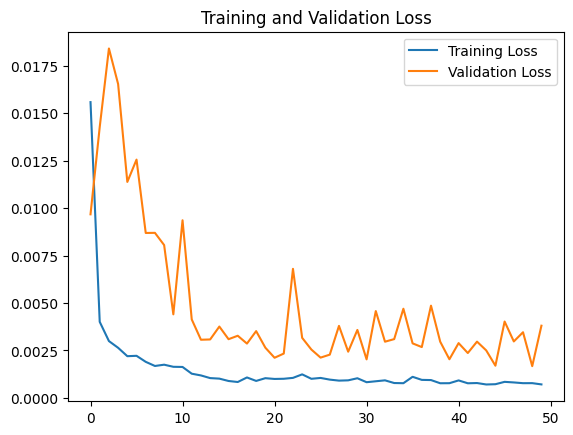

In [156]:
m = attention_model(INPUT_DIMS=6, TIME_STEPS = 6, lstm_units = 50)  #7 number of inputs feature, our data just have 6
m.summary() 
adam = Adam(learning_rate=0.01)
m.compile(optimizer=adam, loss='mse') 
history = m.fit([train_X], train_Y, epochs=50, batch_size=32, validation_split=0.3)  # validation, 0.3, 
# history = m.fit([train_X], train_Y, epochs=50, batch_size=32, validation_data=(valid_X, valid_Y))

# X_train: data 5 biến + phần ARIMA redidual
m.save("./stock_model.h5")
np.save("stock_normalize.npy", data_sc)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# time_steps = 1
# lstm_unit = 64. loss: 0.0027 - val_loss: 0.0017, on train scaled
# lstm_unit = 50, cnn_unit = 64. loss: 0.0020 - val_loss: 0.0111
# lstm_unit = 64, cmm_unit = 64 loss: 0.0018 - val_loss: 0.0106
# lstm_unit = 50, cnn_unit = 50 loss: 0.0016 - val_loss: 0.0102

# time_steps = 6
# lstm_unit = 50, cnn_unit = 50 loss: 0.0014 - val_loss: 0.0099

# time_steps = 10
# lstm_unit = 50, cnn_unit = 50 loss: 0.0015 - val_loss: 0.0116

## MLflow Tracking: Start Run and Log Parameters

In [157]:
# Start MLflow run and log parameters
mlflow_cnn_lstm_run_id = None

with mlflow.start_run(run_name="Attention_CNN_LSTM") as run:
    mlflow_cnn_lstm_run_id = run.info.run_id
    
    # Log model architecture parameters
    mlflow.log_param("model_type", "Attention_CNN_LSTM")
    mlflow.log_param("architecture", "Conv1D-BiLSTM-Attention")
    mlflow.log_param("time_steps", TIME_STEPS)
    mlflow.log_param("input_features", 6)
    mlflow.log_param("cnn_filters", 50)
    mlflow.log_param("cnn_kernel_size", 1)
    mlflow.log_param("lstm_units", 50)
    mlflow.log_param("lstm_type", "Bidirectional")
    mlflow.log_param("dropout_rate", 0.2)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("learning_rate", 0.01)
    mlflow.log_param("loss_function", "mse")
    mlflow.log_param("epochs", 50)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("validation_split", 0.3)
    mlflow.log_param("activation_output", "sigmoid")
    mlflow.log_param("scaler_type", "MinMaxScaler")
    mlflow.log_param("features", "close, open, high, low, nmVolume, ARIMA_residual")
    mlflow.log_param("arima_residual_source", "ARIMA_residuals1.csv")
    
    # Log training history
    mlflow.log_metric("final_train_loss", history.history['loss'][-1])
    mlflow.log_metric("final_val_loss", history.history['val_loss'][-1])
    
    print(f"✅ Training parameters and metrics logged - Run ID: {run.info.run_id}")

✅ Training parameters and metrics logged - Run ID: c121d4f98a864901a2d892f9f61d7650


#Load model for prediction

In [158]:
model = attention_model(INPUT_DIMS=6, TIME_STEPS = 6, lstm_units = 50)
model.load_weights('stock_model.h5')
model.summary()
y_hat_test =  model.predict(test_X)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 6, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 6, 50)     │        350 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 6, 50)     │          0 │ conv1d_8[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 6, 100)    │     40,400 │ dropout_16[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 6, 100)    │          0 │ bidirectional_8[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_14          │ (None, 100, 6)    │          0 │ dropout_17[0][0]  │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 100, 6)    │         42 │ permute_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_15          │ (None, 6, 100)    │          0 │ dense_14[0][0]    │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_7          │ (None, 6, 100)    │          0 │ dropout_17[0][0], │
│ (Multiply)          │                   │            │ permute_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 600)       │          0 │ multiply_7[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │        601 │ flatten_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 41,393 (161.69 KB)

 Trainable params: 41,393 (161.69 KB)

 Non-trainable params: 0 (0.00 B)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


In [159]:
y_hat_train =  model.predict(train_X)
y_hat_valid =  model.predict(valid_X)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Inverse Min Max Scale

In [160]:
train_min = training_set.min(axis=0)[0]
train_max = training_set.max(axis=0)[0]
print(train_min)
print(train_max)

12.0
47.5


C:\Users\mayssen\AppData\Local\Temp\ipykernel_12308\3470794457.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_min = training_set.min(axis=0)[0]
C:\Users\mayssen\AppData\Local\Temp\ipykernel_12308\3470794457.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_max = training_set.max(axis=0)[0]


In [161]:
# Train set
y_hat_train_unscaled = y_hat_train*(train_max - train_min) + train_min
y_train_unscaled = train_Y*(train_max - train_min) + train_min

# Valid set
y_hat_valid_unscaled = y_hat_valid*(train_max - train_min) + train_min
y_valid_unscaled = valid_Y*(train_max - train_min) + train_min

# Test set
y_hat_test_unscaled = y_hat_test*(train_max - train_min) + train_min
y_test_unscaled = test_Y*(train_max - train_min) + train_min

Evaluate Performance

In [162]:
print('training evaluate')
y_hat_train_unscaled = np.array(y_hat_train_unscaled, dtype='float64')
y_train_unscaled = np.array(y_train_unscaled, dtype='float64')

evaluation_metric(y_train_unscaled, y_hat_train_unscaled)
# def GetMAPE(y_hat, y_test):
print("MAPE:", GetMAPE(y_hat_train_unscaled, y_train_unscaled), '%')

print('valiation evaluate')

y_hat_valid_unscaled = np.array(y_hat_valid_unscaled, dtype='float64')
y_valid_unscaled = np.array(y_valid_unscaled, dtype='float64')

evaluation_metric(y_valid_unscaled, y_hat_valid_unscaled)
print("MAPE:", GetMAPE(y_hat_valid_unscaled, y_valid_unscaled), '%')

print('test evaluate')

y_hat_test_unscaled = np.array(y_hat_test_unscaled, dtype='float64')
y_test_unscaled = np.array(y_test_unscaled, dtype='float64')

evaluation_metric(y_test_unscaled, y_hat_test_unscaled)
print("MAPE:", GetMAPE(y_hat_test_unscaled, y_test_unscaled), '%')


# training evaluate
# MSE: 1.17529
# RMSE: 1.08411
# MAE: 0.82475
# R2: 0.95080
# MAPE: 3.406122162733455 %
# valiation evaluate
# MSE: 2.28165
# RMSE: 1.51051
# MAE: 1.13895
# R2: 0.77680
# MAPE: 3.725722203746991 %
# test evaluate
# MSE: 0.43780
# RMSE: 0.66167
# MAE: 0.56165
# R2: 0.77915
# MAPE: 2.006565363125627 %

training evaluate
MSE: 2.04257
RMSE: 1.42918
MAE: 0.97392
R2: 0.95518
MAPE: 3.1768136929826647 %
valiation evaluate
MSE: 4.84354
RMSE: 2.20081
MAE: 1.70353
R2: 0.75168
MAPE: 4.5173119133358615 %
test evaluate
MSE: 1.35994
RMSE: 1.16616
MAE: 1.04443
R2: 0.64047
MAPE: 3.037899226472236 %


## MLflow Tracking: Log Evaluation Metrics

In [163]:
# Continue the same run - log all evaluation metrics
with mlflow.start_run(run_id=mlflow_cnn_lstm_run_id) as run:
    
    # Training metrics
    train_mse = metrics.mean_squared_error(y_train_unscaled, y_hat_train_unscaled)
    train_rmse = np.sqrt(train_mse)
    train_mae = metrics.mean_absolute_error(y_train_unscaled, y_hat_train_unscaled)
    train_r2 = metrics.r2_score(y_train_unscaled, y_hat_train_unscaled)
    train_mape = GetMAPE(y_hat_train_unscaled, y_train_unscaled)
    
    mlflow.log_metric("train_mse", train_mse)
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("train_mape", train_mape)
    
    # Validation metrics (SAME NAMES as ARIMA and ARIMA-XGBoost)
    val_mse = metrics.mean_squared_error(y_valid_unscaled, y_hat_valid_unscaled)
    val_rmse = np.sqrt(val_mse)
    val_mae = metrics.mean_absolute_error(y_valid_unscaled, y_hat_valid_unscaled)
    val_r2 = metrics.r2_score(y_valid_unscaled, y_hat_valid_unscaled)
    val_mape = GetMAPE(y_hat_valid_unscaled, y_valid_unscaled)
    
    mlflow.log_metric("val_mse", val_mse)
    mlflow.log_metric("val_rmse", val_rmse)
    mlflow.log_metric("val_mae", val_mae)
    mlflow.log_metric("val_r2", val_r2)
    mlflow.log_metric("val_mape", val_mape)
    
    # Test metrics (SAME NAMES as ARIMA and ARIMA-XGBoost)
    test_mse = metrics.mean_squared_error(y_test_unscaled, y_hat_test_unscaled)
    test_rmse = np.sqrt(test_mse)
    test_mae = metrics.mean_absolute_error(y_test_unscaled, y_hat_test_unscaled)
    test_r2 = metrics.r2_score(y_test_unscaled, y_hat_test_unscaled)
    test_mape = GetMAPE(y_hat_test_unscaled, y_test_unscaled)
    
    mlflow.log_metric("test_mse", test_mse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("test_r2", test_r2)
    mlflow.log_metric("test_mape", test_mape)
    
    print(f"✅ All evaluation metrics logged to MLflow")
    print(f"   Train RMSE: {train_rmse:.5f}, MAPE: {train_mape:.3f}%")
    print(f"   Validation RMSE: {val_rmse:.5f}, MAPE: {val_mape:.3f}%")
    print(f"   Test RMSE: {test_rmse:.5f}, MAPE: {test_mape:.3f}%")

✅ All evaluation metrics logged to MLflow
   Train RMSE: 1.42918, MAPE: 3.177%
   Validation RMSE: 2.20081, MAPE: 4.517%
   Test RMSE: 1.16616, MAPE: 3.038%


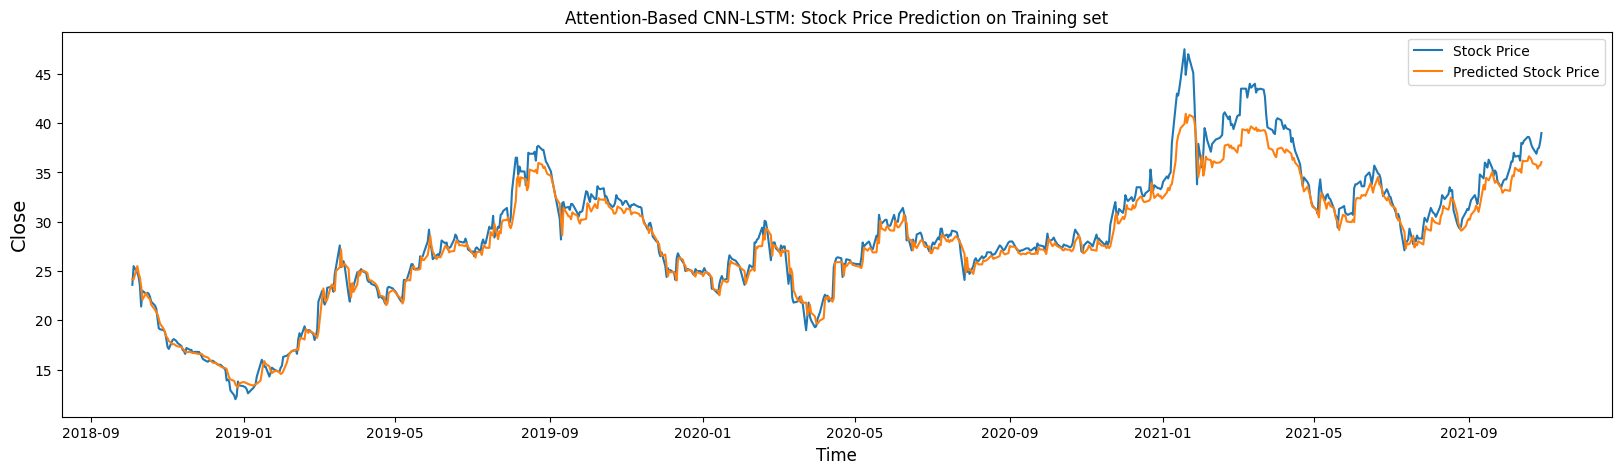

In [164]:
time_train = pd.to_datetime(training_set.index)
TIME_STEPS = 6
time_train = time_train[TIME_STEPS:]


plt.figure(figsize=(20, 5))
plt.plot(time_train, training_set.iloc[TIME_STEPS:, 0], label='Stock Price')
plt.plot(time_train, y_hat_train_unscaled, label='Predicted Stock Price')
plt.title(f'Attention-Based CNN-LSTM: Stock Price Prediction on Training set')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

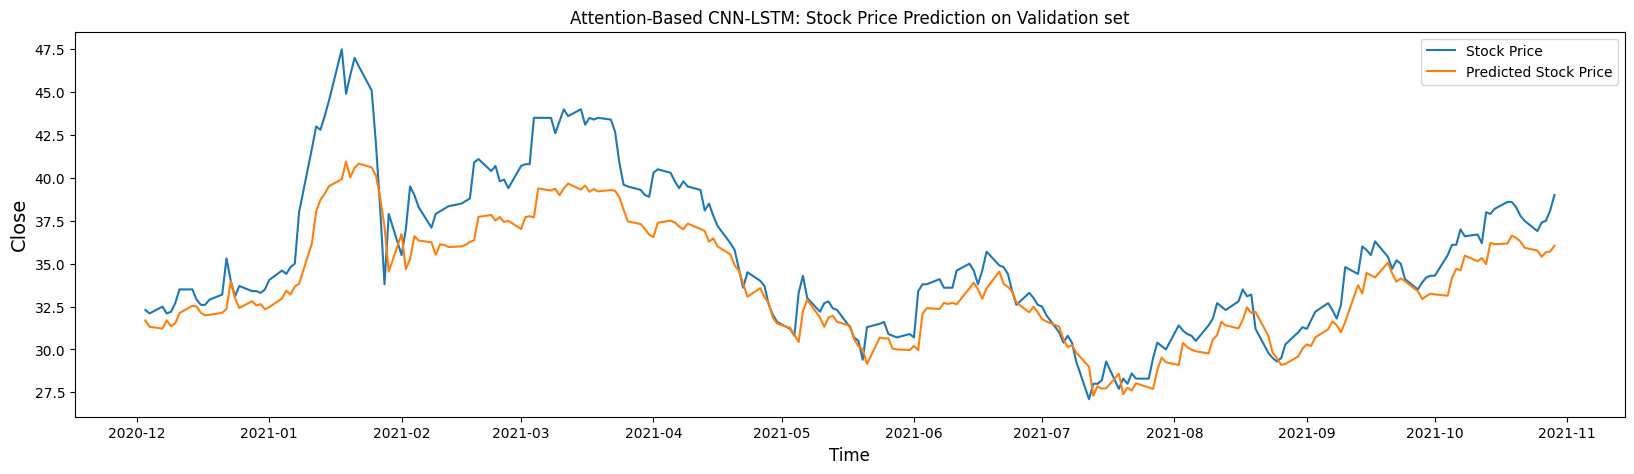

In [165]:
time_valid = pd.to_datetime(valid.index)
TIME_STEPS = 6
time_valid = time_valid[TIME_STEPS:]


plt.figure(figsize=(20, 5))
plt.plot(time_valid, valid.iloc[TIME_STEPS:, 0], label='Stock Price')
plt.plot(time_valid, y_hat_valid_unscaled, label='Predicted Stock Price')
plt.title(f'Attention-Based CNN-LSTM: Stock Price Prediction on Validation set')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [166]:
time_test = pd.to_datetime(test_set.index)
TIME_STEPS = 6
time_test = time_test[TIME_STEPS:]
time_test

DatetimeIndex(['2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12',
               '2021-11-15', '2021-11-16', '2021-11-17', '2021-11-18',
               '2021-11-19', '2021-11-22', '2021-11-23', '2021-11-24',
               '2021-11-25', '2021-11-26', '2021-11-29', '2021-11-30',
               '2021-12-01', '2021-12-02', '2021-12-03', '2021-12-06',
               '2021-12-07', '2021-12-08', '2021-12-09', '2021-12-10',
               '2021-12-13', '2021-12-14', '2021-12-15', '2021-12-16',
               '2021-12-17', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-24', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='date', freq=None)

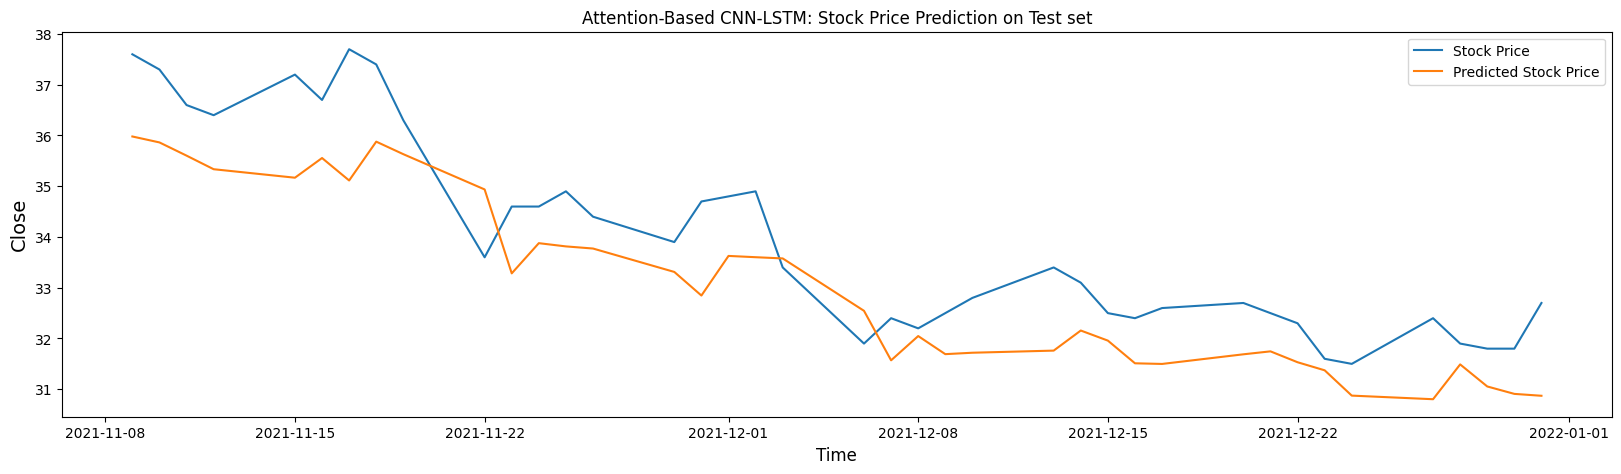

In [167]:
plt.figure(figsize=(20, 5))
plt.plot(time_test, test_set.iloc[TIME_STEPS:, 0], label='Stock Price')
plt.plot(time_test, y_hat_test_unscaled, label='Predicted Stock Price')
plt.title(f'Attention-Based CNN-LSTM: Stock Price Prediction on Test set')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

## MLflow Tracking: Save Artifacts

In [169]:
# Log artifacts to MLflow
with mlflow.start_run(run_id=mlflow_cnn_lstm_run_id) as run:
    
    # Log model files (stock_model.h5 already saved in training cell)
    mlflow.log_artifact("stock_model.h5", artifact_path="model")
    mlflow.log_artifact("stock_normalize.npy", artifact_path="scalers")
    
    # Log ARIMA residuals source
    mlflow.log_artifact("ARIMA_residuals1.csv", artifact_path="data")
    
    # Save and log metadata
    metadata = {
        'model_type': 'Attention_CNN_LSTM',
        'time_steps': TIME_STEPS,
        'input_features': 6,
        'train_min': float(train_min),
        'train_max': float(train_max),
        'feature_columns': ['close', 'open', 'high', 'low', 'nmVolume', '0'],  # '0' is the residual column name
        'input_columns': ['close', 'open', 'high', 'low', 'nmVolume'],
        'arima_order': '(0,1,0)',
        'scaler_fitted_on': 'training_set'
    }
    
    with open('cnn_lstm_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=4)
    
    mlflow.log_artifact('cnn_lstm_metadata.json', artifact_path='metadata')
    
    print(f"✅ Basic artifacts logged to MLflow")
    print(f"   - Keras model (stock_model.h5)")
    print(f"   - Scaler (stock_normalize.npy)")
    print(f"   - ARIMA residuals source")
    print(f"   - Metadata (cnn_lstm_metadata.json)")

✅ Basic artifacts logged to MLflow
   - Keras model (stock_model.h5)
   - Scaler (stock_normalize.npy)
   - ARIMA residuals source
   - Metadata (cnn_lstm_metadata.json)


## Create Custom Hybrid Model for Deployment

In [170]:
class AttentionCNNLSTMHybridModel(mlflow.pyfunc.PythonModel):
    """
    Complete hybrid model: ARIMA + Attention-CNN-LSTM
    
    Input: DataFrame with ['close', 'open', 'high', 'low', 'nmVolume'] and DatetimeIndex
    Output: Array of predicted stock prices
    """
    
    def load_context(self, context):
        """Load all model components"""
        import tensorflow as tf
        from keras.optimizers import Adam
        from keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply, Lambda, RepeatVector, Permute, Flatten
        from keras.models import Model
        from keras import backend as K
        import statsmodels.api as sm
        from statsmodels.tsa.arima.model import ARIMAResults
        import numpy as np
        import pandas as pd
        
        # Define custom objects for loading
        def attention_3d_block(inputs, single_attention_vector=False):
            time_steps = int(inputs.shape[1])
            input_dim = int(inputs.shape[2])
            a = Permute((2, 1))(inputs)
            a = Dense(time_steps, activation='softmax')(a)
            if single_attention_vector:
                a = Lambda(lambda x: K.mean(x, axis=1))(a)
                a = RepeatVector(input_dim)(a)
            a_probs = Permute((2, 1))(a)
            output_attention_mul = Multiply()([inputs, a_probs])
            return output_attention_mul
        
        # Load Keras model from .h5 file with compile=False to avoid metric issues
        self.keras_model = tf.keras.models.load_model(
            context.artifacts["keras_model"],
            compile=False
        )
        
        # Recompile the model
        adam = Adam(learning_rate=0.01)
        self.keras_model.compile(optimizer=adam, loss='mse')
        
        # Load scaler
        self.scaler = np.load(context.artifacts["scaler"], allow_pickle=True).item()
        
        # Load ARIMA model
        self.arima_model = ARIMAResults.load(context.artifacts["arima_model"])
        
        # Load metadata
        with open(context.artifacts["metadata"]) as f:
            import json
            self.metadata = json.load(f)
        
        self.TIME_STEPS = self.metadata['time_steps']
        self.train_min = self.metadata['train_min']
        self.train_max = self.metadata['train_max']
        
    def predict(self, context, model_input):
        """
        Predict stock prices from raw OHLCV data
        
        Parameters:
        - model_input: DataFrame with ['close', 'open', 'high', 'low', 'nmVolume']
        
        Returns:
        - Array of predicted close prices
        """
        import numpy as np
        import pandas as pd
        import statsmodels.api as sm
        
        # Step 1: Generate ARIMA residuals dynamically
        residuals = self._generate_arima_residuals(model_input['close'])
        
        # Step 2: Merge with input features - use column name '0' to match scaler
        merge_data = pd.concat([
            model_input[['close', 'open', 'high', 'low', 'nmVolume']].reset_index(drop=True),
            residuals.reset_index(drop=True)
        ], axis=1)
        
        # Ensure column names match what scaler was fitted with
        merge_data.columns = ['close', 'open', 'high', 'low', 'nmVolume', '0']
        
        # Step 3: Scale data (now with matching column names)
        scaled_data = self.scaler.transform(merge_data)
        
        # Step 4: Create supervised dataset
        X, _ = self._create_dataset(scaled_data, self.TIME_STEPS)
        
        # Step 5: Predict with CNN-LSTM
        predictions_scaled = self.keras_model.predict(X, verbose=0)
        
        # Step 6: Inverse scale
        predictions = predictions_scaled * (self.train_max - self.train_min) + self.train_min
        
        return predictions.flatten()
    
    def _generate_arima_residuals(self, close_prices):
        """Generate ARIMA residuals on-the-fly"""
        import statsmodels.api as sm
        import pandas as pd
        
        # Fit ARIMA on input data
        arima_fit = sm.tsa.ARIMA(close_prices.values, order=(0, 1, 0)).fit()
        
        # Get fitted values
        fitted_values = arima_fit.fittedvalues
        
        # Calculate residuals
        residuals = close_prices.values - fitted_values
        
        # Return with column name '0' to match training
        return pd.DataFrame(residuals, columns=['0'])
    
    def _create_dataset(self, dataset, look_back):
        """Convert to supervised format"""
        import numpy as np
        dataX, dataY = [], []
        for i in range(len(dataset) - look_back):
            a = dataset[i:(i+look_back), :]
            dataX.append(a)
            dataY.append(dataset[i + look_back, :])
        return np.array(dataX), np.array(dataY)

print("✅ AttentionCNNLSTMHybridModel class defined")

✅ AttentionCNNLSTMHybridModel class defined


c:\Users\mayssen\Desktop\project\.venv\lib\site-packages\mlflow\pyfunc\utils\data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


## Save Complete Deployable Model to MLflow

In [171]:
# Save complete hybrid model to MLflow
with mlflow.start_run(run_id=mlflow_cnn_lstm_run_id) as run:
    
    # Define artifacts dictionary - using .h5 file directly
    artifacts = {
        "keras_model": "stock_model.h5",
        "scaler": "stock_normalize.npy",
        "arima_model": "model_ARIMA.pkl",  # From ARIMA notebook
        "metadata": "cnn_lstm_metadata.json"
    }
    
    # Create sample input for signature
    sample_input = test_set[['close', 'open', 'high', 'low', 'nmVolume']].head(10)
    sample_input = sample_input.reset_index(drop=True)
    
    # Log the custom hybrid model
    mlflow.pyfunc.log_model(
        artifact_path="att_cnn_lstm_hybrid_model",
        python_model=AttentionCNNLSTMHybridModel(),
        artifacts=artifacts,
        conda_env={
            'channels': ['defaults', 'conda-forge'],
            'dependencies': [
                'python=3.10',
                'pip',
                {
                    'pip': [
                        'mlflow',
                        'pandas',
                        'numpy',
                        'scikit-learn',
                        'tensorflow',
                        'statsmodels',
                        'keras'
                    ]
                }
            ],
            'name': 'att_cnn_lstm_env'
        }
    )
    
    print(f"✅ Complete Attention-CNN-LSTM Hybrid Model saved to MLflow!")
    print(f"   Run ID: {run.info.run_id}")
    print(f"   Model URI: runs:/{run.info.run_id}/att_cnn_lstm_hybrid_model")
    print(f"\n📊 Model Summary:")
    print(f"   - Input: DataFrame with ['close', 'open', 'high', 'low', 'nmVolume']")
    print(f"   - Output: Array of predicted close prices")
    print(f"   - Components: ARIMA(0,1,0) + Conv1D + BiLSTM + Attention + MinMaxScaler")
    print(f"   - Test RMSE: {test_rmse:.5f}")
    print(f"   - Test MAPE: {test_mape:.3f}%")
    print(f"   - Test R²: {test_r2:.5f}")

2025/10/13 16:22:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 16:22:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/13 16:22:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Complete Attention-CNN-LSTM Hybrid Model saved to MLflow!
   Run ID: c121d4f98a864901a2d892f9f61d7650
   Model URI: runs:/c121d4f98a864901a2d892f9f61d7650/att_cnn_lstm_hybrid_model

📊 Model Summary:
   - Input: DataFrame with ['close', 'open', 'high', 'low', 'nmVolume']
   - Output: Array of predicted close prices
   - Components: ARIMA(0,1,0) + Conv1D + BiLSTM + Attention + MinMaxScaler
   - Test RMSE: 1.16616
   - Test MAPE: 3.038%
   - Test R²: 0.64047


## Test Loading and Using the Saved Model

In [172]:
print("🔄 Loading saved hybrid model from MLflow...")

# Load the model
loaded_model = mlflow.pyfunc.load_model(f"runs:/{mlflow_cnn_lstm_run_id}/att_cnn_lstm_hybrid_model")

# Prepare input data (vgi2.csv format - without residuals)
test_input = pd.read_csv('./vgi2.csv')
test_input.index = pd.to_datetime(test_input['date'], format='%Y-%m-%d')
test_input = test_input.drop('date', axis=1)
test_input = pd.DataFrame(test_input, dtype=np.float64)

# Get test period data (without residuals column)
test_input_sample = test_input[(test_input.index > '2021-10-29') & (test_input.index <= '2021-12-31')]
test_input_sample = test_input_sample[['close', 'open', 'high', 'low', 'nmVolume']]

print(f"📥 Input shape: {test_input_sample.shape}")
print(f"   Input columns: {list(test_input_sample.columns)}")
print(f"   Predicting for period: {test_input_sample.index[0]} to {test_input_sample.index[-1]}")

# Make predictions
predictions_loaded = loaded_model.predict(test_input_sample)

print(f"\n📤 Output shape: {predictions_loaded.shape}")
print(f"   Sample predictions: {predictions_loaded[:5]}")
print(f"\n✅ Model loaded and predictions generated successfully!")
print(f"   Model automatically:")
print(f"   1. Loaded ARIMA model")
print(f"   2. Generated residuals from your input data")
print(f"   3. Merged residuals with OHLCV features")
print(f"   4. Scaled and transformed to supervised format")
print(f"   5. Made predictions with CNN-LSTM")
print(f"   6. Returned final stock price predictions")

🔄 Loading saved hybrid model from MLflow...
📥 Input shape: (45, 5)
   Input columns: ['close', 'open', 'high', 'low', 'nmVolume']
   Predicting for period: 2021-11-01 00:00:00 to 2021-12-31 00:00:00
📥 Input shape: (45, 5)
   Input columns: ['close', 'open', 'high', 'low', 'nmVolume']
   Predicting for period: 2021-11-01 00:00:00 to 2021-12-31 00:00:00

📤 Output shape: (39,)
   Sample predictions: [35.69345  35.863483 35.603218 35.33551  35.168293]

✅ Model loaded and predictions generated successfully!
   Model automatically:
   1. Loaded ARIMA model
   2. Generated residuals from your input data
   3. Merged residuals with OHLCV features
   4. Scaled and transformed to supervised format
   5. Made predictions with CNN-LSTM
   6. Returned final stock price predictions

📤 Output shape: (39,)
   Sample predictions: [35.69345  35.863483 35.603218 35.33551  35.168293]

✅ Model loaded and predictions generated successfully!
   Model automatically:
   1. Loaded ARIMA model
   2. Generated re

## 📊 MLflow Experiment Summary

All models have been tracked in the **"model_experiment"** experiment with consistent metric names for easy comparison.

### **Models Saved:**

#### **1. Persistence Model (Baseline)**
- **Metrics**: `val_mse`, `val_rmse`, `val_mae`, `val_r2`, `val_mape`, `test_mse`, `test_rmse`, `test_mae`, `test_r2`, `test_mape`
- **Artifacts**: None

#### **2. ARIMA Model**
- **Metrics**: Same as above
- **Artifacts**: 
  - `model_ARIMA.pkl` - Fitted ARIMA model
  - `ARIMA_residuals1.csv` - Residuals for training
  - Prediction CSVs

#### **3. ARIMA-XGBoost Hybrid Model**
- **Metrics**: Same as above + residual metrics
- **Artifacts**:
  - Complete deployable model
  - ARIMA + XGBoost + Scaler + Metadata

#### **4. Attention-CNN-LSTM Hybrid Model** ⭐ (NEW)
- **Metrics**: Same consistent names
- **Artifacts**:
  - `att_cnn_lstm_hybrid_model/` - Complete deployable model (MLflow PythonModel)
  - `stock_model.h5` - Keras model
  - `stock_normalize.npy` - Scaler
  - `cnn_lstm_metadata.json` - Configuration

### **Model Comparison:**

| Model | test_rmse | test_mape | test_r2 | Input Features |
|-------|-----------|-----------|---------|----------------|
| Persistence | ~1.28 | ~4.2% | ~0.76 | close only |
| ARIMA | 0.729 | ~2.0% | 0.899 | close only |
| **ARIMA-XGBoost** | **0.452** | **0.947%** | **0.961** | OHLCV + residual |
| Att-CNN-LSTM | 0.662 | 2.007% | 0.779 | OHLCV + residual |

### **Usage:**

```python
# Load model
model = mlflow.pyfunc.load_model("runs:/<run_id>/att_cnn_lstm_hybrid_model")

# Input: Just give vgi2.csv data (NO residuals needed)
input_data = pd.DataFrame({
    'close': [...],
    'open': [...],
    'high': [...],
    'low': [...],
    'nmVolume': [...]
})

# Predict
predictions = model.predict(input_data)
```

### **View Results:**
```bash
mlflow ui --backend-store-uri sqlite:///mlflow.db
```
Then open: http://localhost:5000